In [7]:
import argparse
import numpy as np
import os
import pandas as pd
from gwtrigfind import find_trigger_files
from gwpy.table import EventTable
from gwpy.segments import DataQualityDict
from gwpy.timeseries import TimeSeries
import datetime
from gwpy.time import tconvert
from gwpy.time import from_gps
from gwpy.time import to_gps
from gwpy.segments import Segment
from datetime import timedelta
from itertools import islice
from scipy.signal import correlate
import matplotlib.pyplot as plt
from gwpy.table import Table
import time
import h5py
from gwpy.segments import SegmentList
from gwpy.timeseries import TimeSeriesDict
from gwdetchar import scattering
from gwpy.segments import DataQualityFlag

In [46]:
import seaborn as sns
import matplotlib.style as style
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [125]:
from functions import dataframe_clean
from functions import segs_and_dur
from functions import remove_highblrms, removed_times

In [10]:
t1_L1 = to_gps('2019-11-01')
t1a_L1 = to_gps('2020-01-07')
t2_L1 = to_gps('2020-01-10')
t2a_L1 = to_gps('2020-02-08')

t1_H1 = to_gps('2019-11-01')
t1a_H1 = to_gps('2020-01-14')
t2_H1 = to_gps('2020-01-15')
t2a_H1 = to_gps('2020-02-28')

### Read GravitySpy files for L1 and H1

In [11]:
df_L1_gspy = pd.read_csv('/home/siddharth.soni/gspyO3bNov1_Feb8.csv')
df_H1_gspy = pd.read_csv('/home/siddharth.soni/gspyO3b_scatH1.csv')

In [12]:
df_L1_gspy.describe()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,Q-value
count,5.279600e+04,52796.000000,52796.000000,5.279600e+04,52796.000000,52796.000000,52796.000000,52796.0,52796.0,52796.000000,52796.000000
mean,1.260488e+09,25.933979,20.922504,1.125167e-21,2392.738879,2.355866,4752.614820,0.0,0.0,0.992248,39.168329
std,2.121725e+06,32.727295,31.290939,6.640598e-21,1644.443392,2.129795,3291.551863,0.0,0.0,0.018134,11.832896
min,1.256657e+09,10.090000,8.000000,3.470000e-23,17.809000,0.070000,1.326080,0.0,0.0,0.900000,5.657000
25%,1.259208e+09,21.724000,9.616000,2.460000e-22,56.315000,1.500000,72.419966,0.0,0.0,0.996000,45.255000
50%,1.260258e+09,23.750000,12.544000,4.200000e-22,3027.429000,1.875000,6022.832519,0.0,0.0,1.000000,45.255000
75%,1.262014e+09,26.909000,22.529250,1.710000e-21,3945.515000,2.500000,7860.440430,0.0,0.0,1.000000,45.255000
max,1.265154e+09,2030.474000,3719.541000,8.480000e-19,3998.098000,42.500000,7940.482910,0.0,0.0,1.000000,45.255000


In [13]:
df_H1_gspy.describe()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,Q-value
count,5.868200e+04,58682.000000,58682.000000,5.868200e+04,58682.000000,58682.000000,58682.000000,58682.0,58682.0,58682.000000,58682.000000
mean,1.260233e+09,28.118157,16.717728,9.463653e-22,1377.344340,1.936018,2719.292321,0.0,0.0,0.982990,44.330049
std,1.982739e+06,8.862187,15.088938,2.467985e-20,1336.939119,1.190633,2675.413213,0.0,0.0,0.065893,5.350270
min,1.256666e+09,10.322000,8.000000,3.870000e-23,17.694000,0.094000,0.970600,0.0,0.0,0.225000,5.657000
25%,1.258016e+09,25.356000,9.471000,2.950000e-22,33.821000,1.331000,31.851681,0.0,0.0,1.000000,45.255000
50%,1.260297e+09,27.393000,11.556000,3.690000e-22,1156.036000,1.750000,2277.861084,0.0,0.0,1.000000,45.255000
75%,1.262217e+09,31.035000,16.208750,9.810000e-22,2632.200000,2.250000,5230.273926,0.0,0.0,1.000000,45.255000
max,1.268927e+09,1857.276000,506.121000,3.920000e-18,3989.013000,32.750000,7940.482910,0.0,0.0,1.000000,45.255000


#### Data cleaning (removing duplicates, sorting by GPStime). 

In [14]:
df_L1_gspy = dataframe_clean(df_L1_gspy,'GPStime')
df_H1_gspy = dataframe_clean(df_H1_gspy,'GPStime')

In [15]:
df_L1_gspy.describe()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,Q-value
count,4.969700e+04,49697.000000,49697.000000,4.969700e+04,49697.000000,49697.000000,49697.000000,49697.0,49697.0,49697.000000,49697.000000
mean,1.260656e+09,25.582369,21.055532,1.131160e-21,2391.033105,2.367799,4749.237273,0.0,0.0,0.992613,39.101005
std,2.056427e+06,18.803796,27.388156,6.721878e-21,1642.113666,2.167349,3286.969258,0.0,0.0,0.017762,11.839336
min,1.256657e+09,10.090000,8.000000,3.470000e-23,17.809000,0.070000,1.326080,0.0,0.0,0.900000,5.657000
25%,1.259240e+09,21.724000,9.598000,2.480000e-22,57.083000,1.500000,73.698441,0.0,0.0,0.996000,45.255000
50%,1.260300e+09,23.750000,12.548000,4.270000e-22,3006.608000,1.875000,5983.146973,0.0,0.0,1.000000,45.255000
75%,1.262358e+09,26.909000,22.916000,1.730000e-21,3944.051000,2.500000,7860.440430,0.0,0.0,1.000000,45.255000
max,1.265154e+09,2030.474000,3719.541000,8.480000e-19,3998.098000,42.500000,7940.482910,0.0,0.0,1.000000,45.255000


In [16]:
df_H1_gspy.describe()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,Q-value
count,4.818300e+04,48183.000000,48183.000000,4.818300e+04,48183.000000,48183.000000,48183.000000,48183.0,48183.0,48183.000000,48183.000000
mean,1.260628e+09,28.285678,16.488759,8.616196e-22,1394.363745,1.919707,2752.871225,0.0,0.0,0.996803,44.387967
std,1.795312e+06,4.287046,14.532379,2.283958e-20,1336.026311,1.132618,2673.424607,0.0,0.0,0.012091,5.137409
min,1.256670e+09,10.322000,8.000000,3.940000e-23,18.855000,0.250000,0.970600,0.0,0.0,0.900000,5.657000
25%,1.259215e+09,25.507000,9.556000,2.950000e-22,35.009000,1.375000,32.994301,0.0,0.0,1.000000,45.255000
50%,1.260564e+09,27.868000,11.607000,3.690000e-22,1184.773000,1.750000,2331.715820,0.0,0.0,1.000000,45.255000
75%,1.262335e+09,31.035000,16.116000,7.160000e-22,2634.220000,2.250000,5234.229980,0.0,0.0,1.000000,45.255000
max,1.268927e+09,269.285000,506.121000,3.920000e-18,3989.013000,32.750000,7940.482910,0.0,0.0,1.000000,45.255000


#### These dataframe contains GravitySpy Scattering triggers with confidence above 0.9 and SNR above 8. The L1 file contains triggers from Nov, 1, 2019 to Feb, 8, 2020 and the H1 file contains triggers from Nov, 1, 2019 to March, 22, 2020.

### Segments

In [17]:
segsL1_pre,durL1_pre = segs_and_dur(t1_L1,t1a_L1,'L1')
segsL1_post,durL1_post = segs_and_dur(t2_L1,t2a_L1,'L1')

In [18]:
segsH1_pre,durH1_pre = segs_and_dur(t1_H1,t1a_H1,'H1')
segsH1_post,durH1_post = segs_and_dur(t2_H1,t2a_H1,'H1')

#### Pre to Post duration ratio

In [19]:
durfacL1, durfacH1 = durL1_pre/durL1_post, durH1_pre/durH1_post

In [20]:
durfacL1,durfacH1

(2.3819892316929097, 1.654457735353968)

## Ground motion files

In [21]:
datapre_L1 = np.load('preRzero_O3bX_observe_only_NEW.py',allow_pickle=True,encoding='latin1').item()
datapost_L1 = np.load('postRzero_O3bX_observe_only_NEW.npy',allow_pickle=True,encoding='latin1').item()

In [22]:
datapre_H1 =  TimeSeriesDict.read('pre_rzeroH1.hdf5')
datapost_H1 = TimeSeriesDict.read('post_rzeroH1.hdf5')

## Livingston ground motion and scattering triggers

#### Microseism

In [23]:
micro_pre_L1 =  TimeSeries(datapre_L1['L1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M_observe'],
                              times=datapre_L1['L1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M_observe_times'])
micro_post_L1 = TimeSeries(datapost_L1['L1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M_observe'],
                               times=datapost_L1['L1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M_observe_times'])

In [24]:
count_micropre,division_micropre = np.histogram(micro_pre_L1,bins=np.arange(100,2100,100))
count_micropost,division_micropost = np.histogram(micro_post_L1,bins=np.arange(100,2100,100))

#### Earthquake band

In [25]:
eq_pre_L1 = TimeSeries(datapre_L1['L1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M_observe'],
                       times = datapre_L1['L1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M_observe_times'])
eq_post_L1 = TimeSeries(datapost_L1['L1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M_observe'],
                        times = datapost_L1['L1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M_observe_times'])

In [26]:
count_eqpre,division_eqpre = np.histogram(eq_pre_L1,bins=np.arange(0,1050,50))
count_eqpost,division_eqpost = np.histogram(eq_post_L1,bins=np.arange(0,1050,50))

#### SNR 

In [27]:
count_presnrL1,division_presnrL1 = np.histogram(df_L1_gspy[(df_L1_gspy.GPStime<to_gps('2020-01-07'))]['snr'],bins=np.arange(10,110,5))
count_postsnrL1,division_postsnrL1 = np.histogram(df_L1_gspy[(df_L1_gspy.GPStime>=to_gps('2020-01-10'))]['snr'],bins=np.arange(10,110,5))

### Compare Ground motion and SNR Pre and Post RC tracking

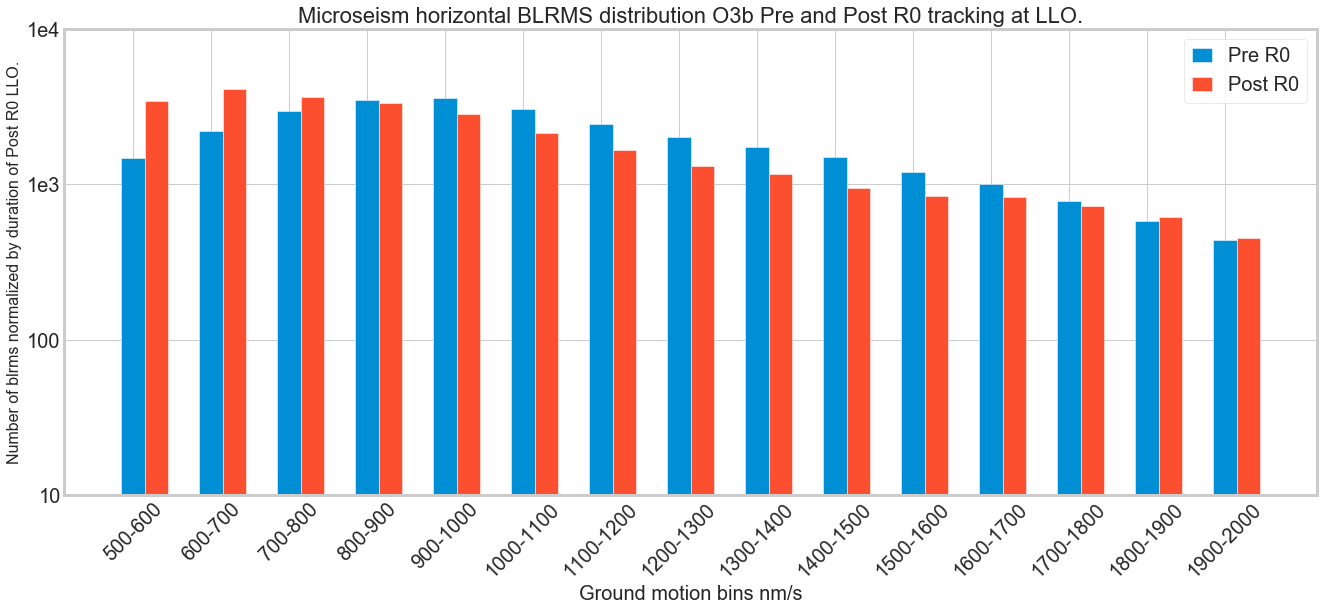

In [47]:
plt.figure(figsize=(20,8))
x = np.arange(len(division_micropost[4:])-1)
w = 0.3
plt.bar(x,count_micropre[4:]/durfacL1,width=w,label='Pre R0')
plt.bar(x+w,count_micropost[4:],width=w,label='Post R0')
tcks = [str(division_micropost[i])+'-'+str(division_micropost[i+1]) for i in range(4,len(division_micropost)-1)]
plt.xticks(x,tcks,fontsize=20,rotation='45')
#plt.grid(True,which='both')
plt.yscale('log')
plt.yticks([10,100,1000,1e4],[10,100,'1e3','1e4'],fontsize=20)
plt.ylim(10,1e4)
plt.xlabel('Ground motion bins nm/s',fontsize=20)
plt.ylabel('Number of blrms normalized by duration of Post R0 LLO.',fontsize=16)
plt.title('Microseism horizontal BLRMS distribution O3b Pre and Post R0 tracking at LLO.',fontsize=22)
plt.legend(fontsize=20)
plt.show()

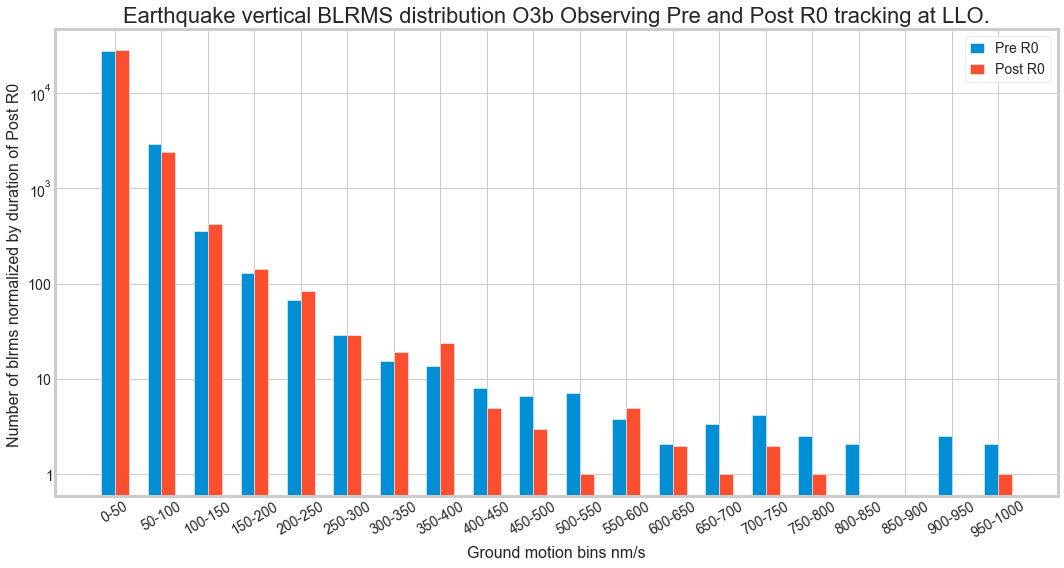

In [48]:
plt.figure(figsize=(16,8))
x = np.arange(len(division_eqpost)-1)
w = 0.3
plt.bar(x,count_eqpre/durfacL1,width=w,label='Pre R0')
plt.bar(x+w,count_eqpost,width=w,label='Post R0')
tcks = [str(division_eqpost[i])+'-'+str(division_eqpost[i+1]) for i in range(len(division_eqpost)-1)]
plt.xticks(x + w/2,tcks,rotation='-330')
plt.yscale('log')
plt.xlabel('Ground motion bins nm/s',fontsize=16)
plt.ylabel('Number of blrms normalized by duration of Post R0 ',fontsize=16)
plt.title('Earthquake vertical BLRMS distribution O3b Observing Pre and Post R0 tracking at LLO.',fontsize=22)
plt.legend()
plt.show()

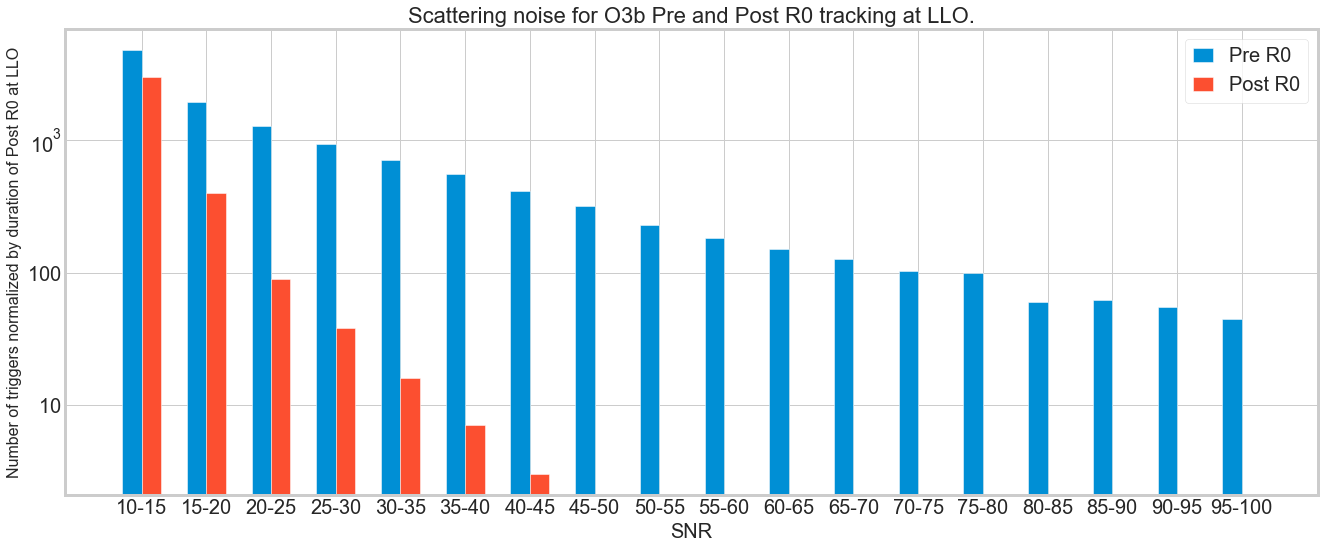

In [49]:
plt.figure(figsize=(20,8))
x = np.arange(len(division_postsnrL1)-1)[:-1]
w = 0.3
plt.bar(x,count_presnrL1[:-1]/durfacL1,width=w,label='Pre R0')
plt.bar(x+w,count_postsnrL1[:-1],width=w,label='Post R0')
tcks = [str(division_postsnrL1[i])+'-'+str(division_postsnrL1[i+1]) for i in range(len(division_postsnrL1)-1)]
plt.xticks(x + w/2,tcks,size=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.xlabel('SNR',fontsize=20)
plt.ylabel('Number of triggers normalized by duration of Post R0 at LLO',fontsize=16)
plt.title('Scattering noise for O3b Pre and Post R0 tracking at LLO.',fontsize=22)
plt.legend(fontsize=20)
plt.show()

## Hanford Ground motion and Scattering triggers

### Microseism

In [50]:
micro_post_H1 = datapost_H1['H1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M.mean']
micro_pre_H1 = datapre_H1['H1:ISI-GND_STS_ETMX_X_BLRMS_100M_300M.mean']

#### Getting only observing data

In [51]:
indicespost = np.nonzero([x not in segsH1_post for x in micro_post_H1.times.value])
micro_post_H1.value[indicespost] = np.nan

indicespre = np.nonzero([x not in segsH1_pre for x in micro_pre_H1.times.value])
micro_pre_H1.value[indicespre] = np.nan

In [52]:
count_micropostH1,division_micropostH1 = np.histogram(micro_post_H1,bins=np.arange(100,2100,100))
count_micropreH1,division_micropreH1 = np.histogram(micro_pre_H1,bins=np.arange(100,2100,100))

### Earthquake band

In [53]:
eq_post_H1 = datapost_H1['H1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M.mean']
eq_pre_H1 = datapre_H1['H1:ISI-GND_STS_ETMX_Z_BLRMS_30M_100M.mean']

#### Getting only observing data

In [54]:
indicesposteq = np.nonzero([x not in segsH1_post for x in eq_post_H1.times.value])
eq_post_H1.value[indicesposteq] = np.nan

indicespreeq = np.nonzero([x not in segsH1_pre for x in eq_pre_H1.times.value])
eq_pre_H1.value[indicespreeq] = np.nan

In [55]:
count_eqpostH1,division_eqpostH1 = np.histogram(eq_post_H1,bins=np.arange(0,1250,50))
count_eqpreH1,division_eqpreH1 = np.histogram(eq_pre_H1,bins=np.arange(0,1250,50))

### SNR

In [56]:
count_presnrH1,division_presnrH1 = np.histogram(df_H1_gspy[(df_H1_gspy.GPStime<=to_gps('2020-01-14'))]['snr'],bins=np.arange(10,110,5))
count_postsnrH1,division_postsnrH1 = np.histogram(df_H1_gspy[(df_H1_gspy.GPStime>=to_gps('2020-01-15')) & 
                                                             (df_H1_gspy.GPStime<=to_gps('2020-02-28'))]['snr'],bins=np.arange(10,110,5))

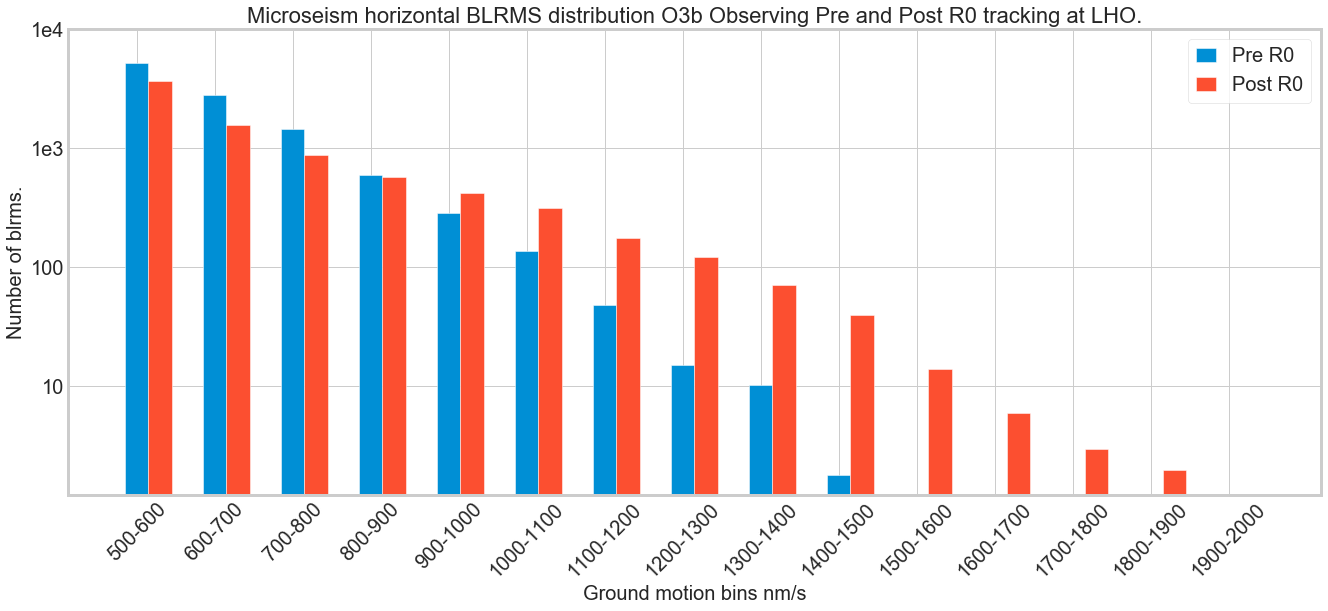

In [57]:
plt.figure(figsize=(20,8))
x = np.arange(len(division_micropostH1[4:])-1)
w = 0.3
plt.bar(x,count_micropreH1[4:]/durfacH1,width=w,label='Pre R0')
plt.bar(x+w,count_micropostH1[4:],width=w,label='Post R0')
tcks = [str(division_micropostH1[i])+'-'+str(division_micropostH1[i+1]) for i in range(4,len(division_micropostH1)-1)]
plt.xticks(x,tcks,fontsize=20,rotation='45')
plt.yscale('log')
plt.yticks([10,100,1000,10000],[10,100,'1e3','1e4'],fontsize=20)
plt.xlabel('Ground motion bins nm/s',fontsize=20)
plt.ylabel('Number of blrms.',fontsize=20)
plt.title('Microseism horizontal BLRMS distribution O3b Observing Pre and Post R0 tracking at LHO.',fontsize=22)
plt.legend(fontsize=20)
plt.show()

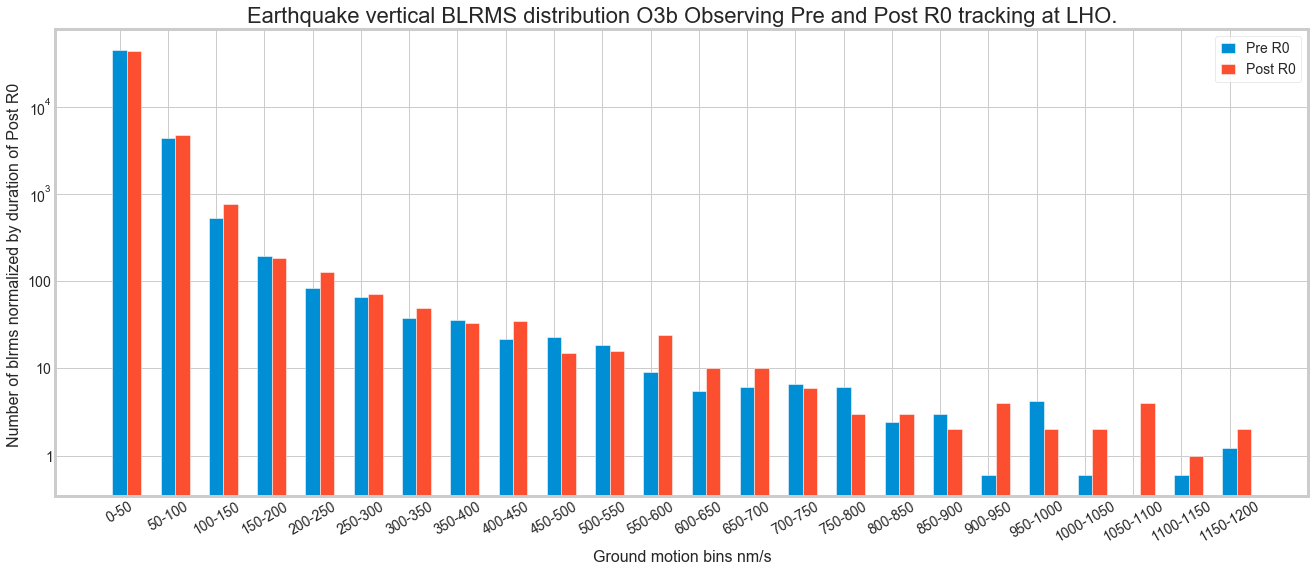

In [58]:
plt.figure(figsize=(20,8))
x = np.arange(len(division_eqpostH1)-1)
w = 0.3
plt.bar(x,count_eqpreH1/durfacH1,width=w,label='Pre R0')
plt.bar(x+w,count_eqpostH1,width=w,label='Post R0')
tcks = [str(division_eqpostH1[i])+'-'+str(division_eqpostH1[i+1]) for i in range(len(division_eqpostH1)-1)]
plt.xticks(x,tcks,fontsize=14,rotation='-330')
plt.yscale('log')
plt.xlabel('Ground motion bins nm/s',fontsize=16)
plt.ylabel('Number of blrms normalized by duration of Post R0 ',fontsize=16)
plt.title('Earthquake vertical BLRMS distribution O3b Observing Pre and Post R0 tracking at LHO.',fontsize=22)
plt.legend()
plt.show()

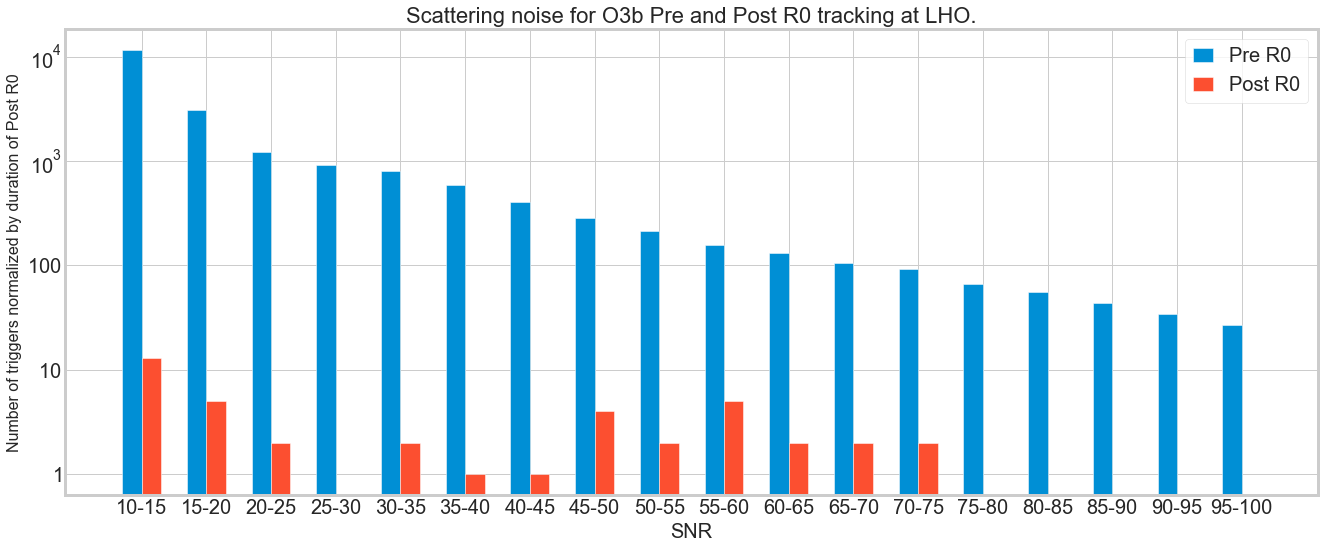

In [59]:
plt.figure(figsize=(20,8))
x = np.arange(len(division_postsnrH1)-1)[:-1]
w = 0.3
plt.bar(x,count_presnrH1[:-1]/durfacH1,width=w,label='Pre R0')
plt.bar(x+w,count_postsnrH1[:-1],width=w,label='Post R0')
tcks = [str(division_postsnrH1[i])+'-'+str(division_postsnrH1[i+1]) for i in range(len(division_postsnrH1)-1)]
plt.xticks(x + w/2,tcks,size=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.xlabel('SNR',fontsize=20)
plt.ylabel('Number of triggers normalized by duration of Post R0',fontsize=16)
plt.title('Scattering noise for O3b Pre and Post R0 tracking at LHO.',fontsize=22)
plt.legend(fontsize=20)
plt.show()

### Now we will compare the SNR plots for same level of microseism above 900 nm/s for before and after RC tracking. For this we will remove those time segments where the ground motion is larger either in Pre or Post RC tracking data and then we will replot the SNR distribution after removing triggers from the removed time segments.

In [64]:
count_micropre[8:]/durfacL1,division_micropre[8:]

(array([3578.9414522 , 3055.00961263, 2421.08567212,
        1998.7495899 , 1743.92056216, 1492.03025468,
        1201.09694953, 1004.20269251,  784.21849064,
         576.82880414,  439.12876938]),
 array([ 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
        1800, 1900, 2000]))

In [63]:
count_micropost[8:],division_micropost[8:]

(array([2822, 2121, 1658, 1315, 1169,  942,  844,  830,  726,
         612,  451]),
 array([ 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
        1800, 1900, 2000]))

In [69]:
blrmsL1 = [int(i) for i in count_micropost[8:-2]*durfacL1]
blrmsL1

[6721, 5052, 3949, 3132, 2784, 2243, 2010, 1977, 1729]

In [74]:
band_blrmsL1 = list(zip(list(np.arange(900,2100,100)),blrmsL1))
band_blrmsL1

[(900, 6721),
 (1000, 5052),
 (1100, 3949),
 (1200, 3132),
 (1300, 2784),
 (1400, 2243),
 (1500, 2010),
 (1600, 1977),
 (1700, 1729)]

In [71]:
times_segsL1 = removed_times(micro_pre_L1,band_blrmsL1)

/home/siddharth.soni/Scattering_Project/functions.py:47: RuntimeWarning: invalid value encountered in greater
  ar1 = motion_file[(motion_file.value>value) & (motion_file.value<value+100)].times.value
/home/siddharth.soni/Scattering_Project/functions.py:47: RuntimeWarning: invalid value encountered in less
  ar1 = motion_file[(motion_file.value>value) & (motion_file.value<value+100)].times.value


In [73]:
np.sum([i.end-i.start for i in times_segsL1])

693720.0

In [75]:
count_microprea,division_microprea = np.histogram(micro_pre_L1,bins=np.arange(100,2100,100))
count_microposta,division_microposta = np.histogram(micro_post_L1,bins=np.arange(100,2100,100))

In [79]:
count_microposta[8:],count_microprea[8:]/durfacL1

(array([2822, 2121, 1658, 1315, 1169,  942,  844,  830,  726,
         612,  451]), array([2821.59126102, 2120.91638903, 1657.85804044,
        1314.86740508, 1168.77102674,  941.64993282,
         843.83253008,  829.97856317,  725.86390274,
         576.82880414,  439.12876938]))

### They are equal, lets now plot the microseism ground motion again

#### Remove the triggers in the segments times_segsL1

In [82]:
removed_trigsL1 = [i for i in df_L1_gspy['GPStime'] for j in times_segsL1 if i in j]

In [83]:
len(removed_trigsL1)

5983

In [84]:
df_L1_gspy_new = df_L1_gspy[~df_L1_gspy['GPStime'].isin(removed_trigsL1)]
df_L1_gspy_new = df_L1_gspy_new.reset_index(drop=True)
df_L1_gspy_new.describe()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,Q-value
count,4.371400e+04,43714.000000,43714.000000,4.371400e+04,43714.000000,43714.000000,43714.000000,43714.0,43714.0,43714.000000,43714.000000
mean,1.260557e+09,25.659792,21.553918,1.170517e-21,2404.413965,2.409011,4776.116322,0.0,0.0,0.992218,38.708285
std,2.167919e+06,19.840072,28.690435,7.156695e-21,1642.153624,2.260528,3287.127624,0.0,0.0,0.018181,12.057402
min,1.256657e+09,10.090000,8.000000,3.470000e-23,17.809000,0.070000,1.326080,0.0,0.0,0.900000,5.657000
25%,1.259220e+09,21.724000,9.588000,2.520000e-22,62.062500,1.500000,91.492056,0.0,0.0,0.996000,45.255000
50%,1.260226e+09,23.515000,12.598500,4.660000e-22,3030.340000,1.938000,6029.563477,0.0,0.0,1.000000,45.255000
75%,1.262385e+09,26.909000,23.581500,1.750000e-21,3945.515000,2.520000,7863.368164,0.0,0.0,1.000000,45.255000
max,1.265154e+09,2030.474000,3719.541000,8.480000e-19,3998.098000,42.500000,7940.482910,0.0,0.0,1.000000,45.255000


#### Updated L1 SNR distribution for equal microseism ground motion

In [86]:
count_presnrL1a,division_presnrL1a = np.histogram(df_L1_gspy_new[(df_L1_gspy_new.GPStime<to_gps('2020-01-07'))]['snr'],bins=np.arange(10,110,5))
count_postsnrL1a,division_postsnrL1a = np.histogram(df_L1_gspy_new[(df_L1_gspy_new.GPStime>=to_gps('2020-01-10'))]['snr'],bins=np.arange(10,110,5))

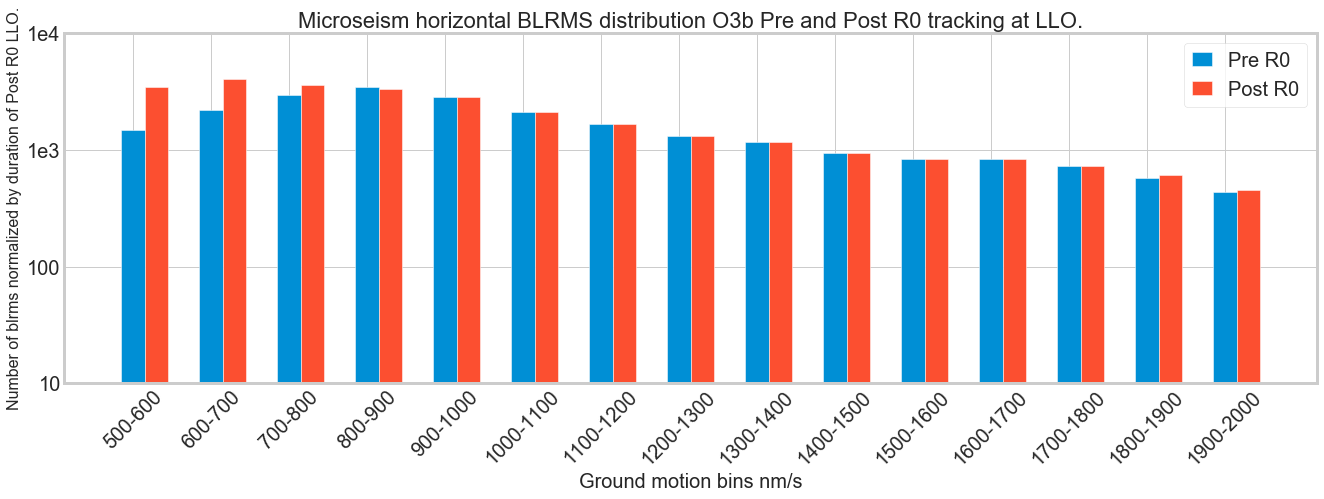

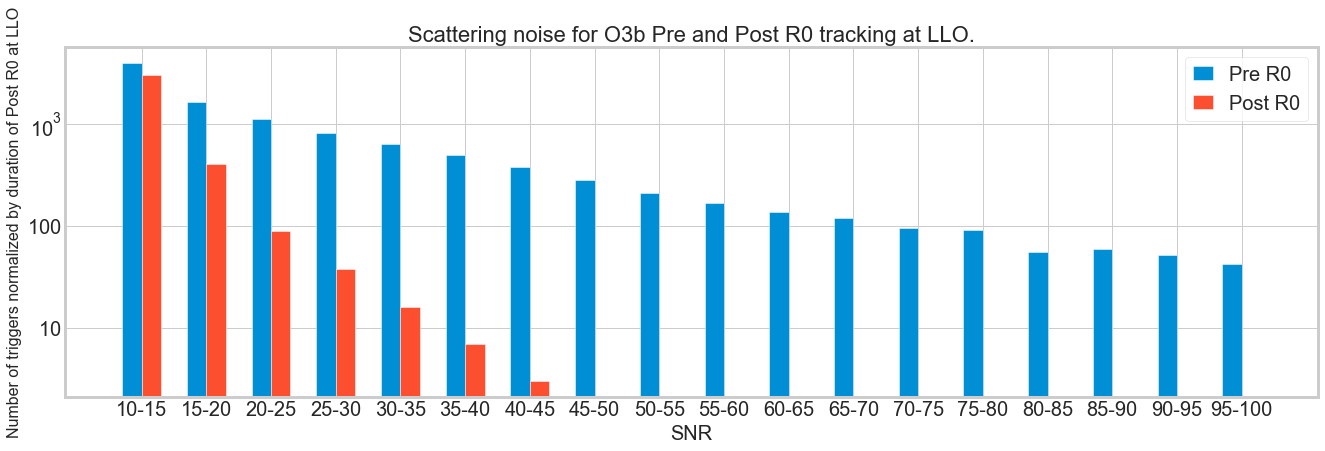

In [124]:
plt.figure(figsize=(20,6))
x = np.arange(len(division_microposta[4:])-1)
w = 0.3
plt.bar(x,count_microprea[4:]/durfacL1,width=w,label='Pre R0')
plt.bar(x+w,count_microposta[4:],width=w,label='Post R0')
tcks = [str(division_microposta[i])+'-'+str(division_microposta[i+1]) for i in range(4,len(division_microposta)-1)]
plt.xticks(x,tcks,fontsize=20,rotation='45')
#plt.grid(True,which='both')
plt.yscale('log')
plt.yticks([10,100,1000,1e4],[10,100,'1e3','1e4'],fontsize=20)
plt.ylim(10,1e4)
plt.xlabel('Ground motion bins nm/s',fontsize=20)
plt.ylabel('Number of blrms normalized by duration of Post R0 LLO.',fontsize=16)
plt.title('Microseism horizontal BLRMS distribution O3b Pre and Post R0 tracking at LLO.',fontsize=22)
plt.legend(fontsize=20)
plt.show()

plt.figure(figsize=(20,6))
x = np.arange(len(division_postsnrL1a)-1)[:-1]
w = 0.3
plt.bar(x,count_presnrL1a[:-1]/durfacL1,width=w,label='Pre R0')
plt.bar(x+w,count_postsnrL1a[:-1],width=w,label='Post R0')
tcks = [str(division_postsnrL1a[i])+'-'+str(division_postsnrL1a[i+1]) for i in range(len(division_postsnrL1a)-1)]
plt.xticks(x + w/2,tcks,size=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.xlabel('SNR',fontsize=20)
plt.ylabel('Number of triggers normalized by duration of Post R0 at LLO',fontsize=16)
plt.title('Scattering noise for O3b Pre and Post R0 tracking at LLO.',fontsize=22)
plt.legend(fontsize=20)
plt.show()

### We will now do a similar analysis for H1

In [114]:
[int(i) for i in count_micropreH1[8:]/durfacH1],division_micropreH1[8:]

([283, 136, 48, 15, 10, 1, 0, 0, 0, 0, 0],
 array([ 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
        1800, 1900, 2000]))

In [105]:
count_micropostH1[8:],division_micropostH1[8:]

(array([416, 314, 175, 122,  71,  40,  14,   6,   3,   2,   0]),
 array([ 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
        1800, 1900, 2000]))

#### We will make the post blrms equal to pre blrms when normalized by the duration

In [108]:
blrmsH1 = [283, 136, 48, 15, 10, 1, 0, 0, 0, 0] 
band_blrmsH1 = list(zip(list(np.arange(900,1900,100)),blrmsH1)) # last bin is equal (0) for both pre and post, so dont need to include that
band_blrmsH1

[(900, 283),
 (1000, 136),
 (1100, 48),
 (1200, 15),
 (1300, 10),
 (1400, 1),
 (1500, 0),
 (1600, 0),
 (1700, 0),
 (1800, 0)]

In [109]:
times_segsH1 = removed_times(micro_post_H1,band_blrmsH1)

/home/siddharth.soni/Scattering_Project/functions.py:47: RuntimeWarning: invalid value encountered in greater
  ar1 = motion_file[(motion_file.value>value) & (motion_file.value<value+100)].times.value
/home/siddharth.soni/Scattering_Project/functions.py:47: RuntimeWarning: invalid value encountered in less
  ar1 = motion_file[(motion_file.value>value) & (motion_file.value<value+100)].times.value


#### Updated microseism blrms for H1

In [111]:
count_micropostH1a,division_micropostH1a = np.histogram(micro_post_H1,bins=np.arange(100,2100,100))
count_micropreH1a,division_micropreH1a = np.histogram(micro_pre_H1,bins=np.arange(100,2100,100))

#### Remove the triggers in the segments times_segsH1

In [115]:
removed_trigsH1 = [i for i in df_H1_gspy['GPStime'] for j in times_segsH1 if i in j]

In [116]:
df_H1_gspy_new = df_H1_gspy[~df_H1_gspy['GPStime'].isin(removed_trigsH1)]
df_H1_gspy_new = df_H1_gspy_new.reset_index(drop=True)
df_H1_gspy_new.describe()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,Q-value
count,4.817200e+04,48172.000000,48172.000000,4.817200e+04,48172.000000,48172.000000,48172.000000,48172.0,48172.0,48172.000000,48172.000000
mean,1.260627e+09,28.286741,16.484589,8.603680e-22,1394.091465,1.919092,2752.324071,0.0,0.0,0.996812,44.388239
std,1.795023e+06,4.286412,14.527160,2.284152e-20,1335.908148,1.131604,2673.185936,0.0,0.0,0.012069,5.137024
min,1.256670e+09,10.322000,8.000000,3.940000e-23,18.855000,0.250000,0.970600,0.0,0.0,0.900000,5.657000
25%,1.259215e+09,25.507000,9.556000,2.950000e-22,35.009000,1.375000,32.914002,0.0,0.0,1.000000,45.255000
50%,1.260564e+09,27.868000,11.606500,3.690000e-22,1184.113000,1.750000,2330.058594,0.0,0.0,1.000000,45.255000
75%,1.262335e+09,31.035000,16.112250,7.070000e-22,2634.220000,2.250000,5234.229980,0.0,0.0,1.000000,45.255000
max,1.268927e+09,269.285000,506.121000,3.920000e-18,3989.013000,32.750000,7940.482910,0.0,0.0,1.000000,45.255000


#### Updated H1 SNR distribution for equal microseism ground motion

In [119]:
count_presnrH1a,division_presnrH1a = np.histogram(df_H1_gspy_new[(df_H1_gspy_new.GPStime<=to_gps('2020-01-14'))]['snr'],bins=np.arange(10,110,5))
count_postsnrH1a,division_postsnrH1a = np.histogram(df_H1_gspy_new[(df_H1_gspy_new.GPStime>=to_gps('2020-01-15')) & 
                                                             (df_H1_gspy_new.GPStime<=to_gps('2020-02-28'))]['snr'],bins=np.arange(10,110,5))

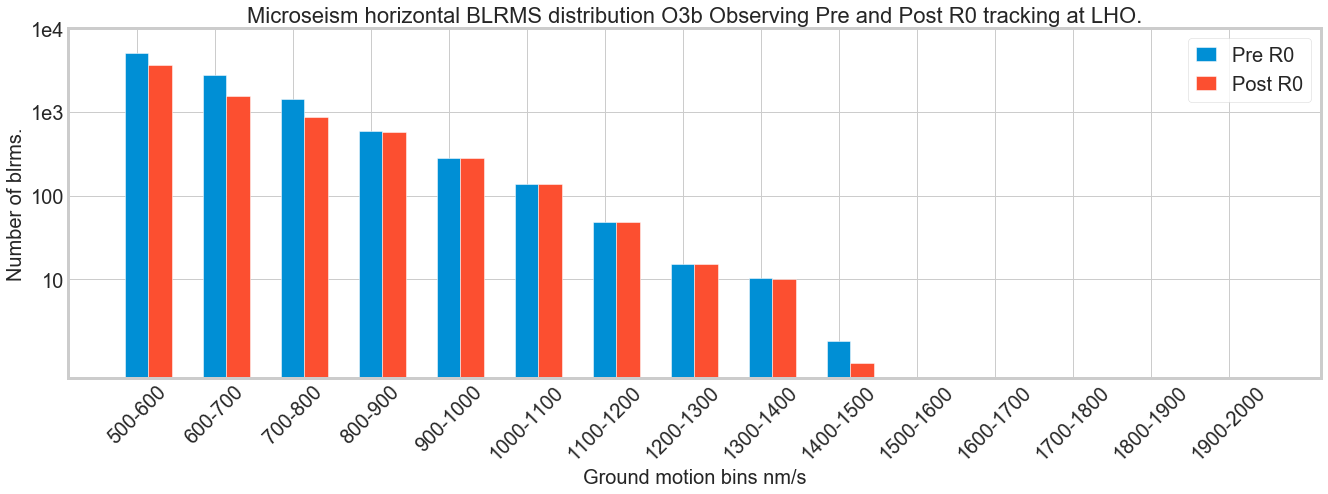

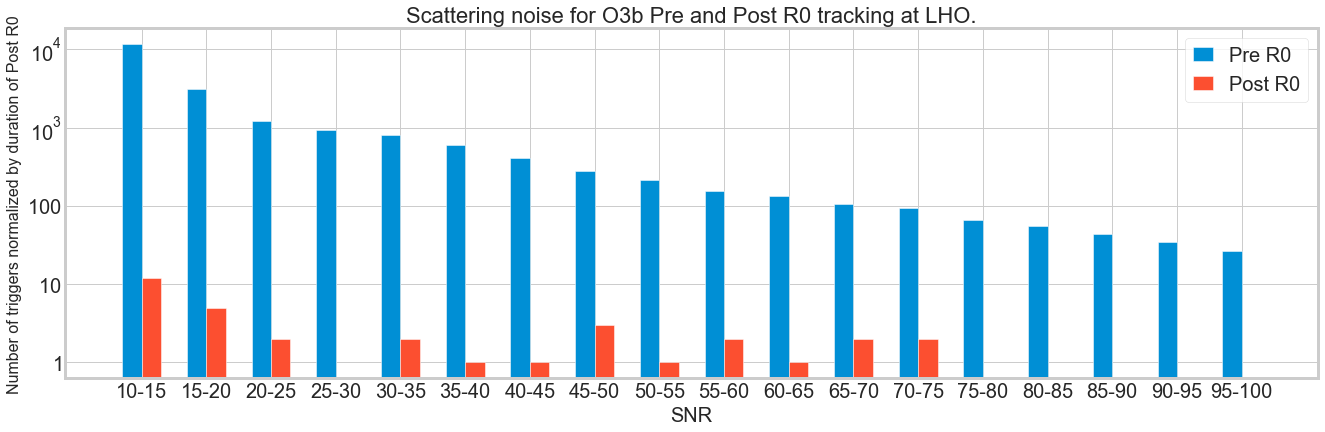

In [123]:
plt.figure(figsize=(20,6))
x = np.arange(len(division_micropostH1a[4:])-1)
w = 0.3
plt.bar(x,count_micropreH1a[4:]/durfacH1,width=w,label='Pre R0')
plt.bar(x+w,count_micropostH1a[4:],width=w,label='Post R0')
tcks = [str(division_micropostH1a[i])+'-'+str(division_micropostH1a[i+1]) for i in range(4,len(division_micropostH1a)-1)]
plt.xticks(x,tcks,fontsize=20,rotation='45')
plt.yscale('log')
plt.yticks([10,100,1000,10000],[10,100,'1e3','1e4'],fontsize=20)
plt.xlabel('Ground motion bins nm/s',fontsize=20)
plt.ylabel('Number of blrms.',fontsize=20)
plt.title('Microseism horizontal BLRMS distribution O3b Observing Pre and Post R0 tracking at LHO.',fontsize=22)
plt.legend(fontsize=20)
plt.show()

plt.figure(figsize=(20,6))
x = np.arange(len(division_postsnrH1a)-1)[:-1]
w = 0.3
plt.bar(x,count_presnrH1a[:-1]/durfacH1,width=w,label='Pre R0')
plt.bar(x+w,count_postsnrH1a[:-1],width=w,label='Post R0')
tcks = [str(division_postsnrH1a[i])+'-'+str(division_postsnrH1a[i+1]) for i in range(len(division_postsnrH1a)-1)]
plt.xticks(x + w/2,tcks,size=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.xlabel('SNR',fontsize=20)
plt.ylabel('Number of triggers normalized by duration of Post R0',fontsize=16)
plt.title('Scattering noise for O3b Pre and Post R0 tracking at LHO.',fontsize=22)
plt.legend(fontsize=20)
plt.show()